오늘 날짜 : 2022-02-09
GPU device : cuda:2
image.size() =  torch.Size([128, 1, 32, 32]) 	type torch.FloatTensor
label.size() =  torch.Size([128]) 	type torch.LongTensor


<Figure size 720x72 with 0 Axes>

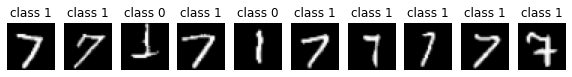

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt 
import math
import itertools
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.autograd import Variable

import time
import datetime

args = {
        'GPU_NUM' : 2,
        'Epochs' : 200,
        'batch_size' : 128,
        'lr' : 0.0002,
        'b1' : 0.5,
        'b2' : 0.999,
        'latent_dim' : 62,
        'code_dim' : 2,
        'n_classes' : 2,
        'img_size' : 32,
        'channels' : 1,
        'sample_interval' : 400
        }

device = torch.device('cuda:{}'.format(args['GPU_NUM']) if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
today = datetime.date.today()
print('오늘 날짜 :',today)
print('GPU device :', device)

my_transform =transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(args['img_size']), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])])

train_data = ImageFolder('MNIST/classes/binary/train', transform = my_transform)
test_data = ImageFolder('MNIST/classes/binary/test', transform = my_transform)

train_loader = DataLoader(train_data, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=args['batch_size'], shuffle=True)

pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))
for image, label in train_loader:
    print('image.size() = ',image.size(), '\ttype', image.type())
    print('label.size() = ', label.size(), '\ttype', label.type())
    break

plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(image[i,:,:,:].permute(1,2,0), cmap="gray")
    plt.title('class '+ str(label[i].item()))

In [7]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

def weights_init_normal(m):
    """ Conv layer는 mean이 0, std가 0.02인 가우시안 분포로 weight init
        BatchNorm은 mean이 1, std가 0.02인 가우시안 분포로 weight init
        Bias term은 전부 0으로 초기화
    Args:
        m ([model]): 학습하려는 모델
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def to_discrete(y, num_columns):
    """ onehot encoding
        (batch_size,)가 shape인 label이 있으면, (64,num_columns)인 zeros 행렬을 생성하고,
        (batch_size,)의 label vector element 값의 index만 1로 바꿔서 one-hot encoding함
    Args:
        y : 어떤 array (y.shape[0]는 batch_size로 보면 됨)
        num_columns : num_classes
    """
    y_disc = np.zeros((y.shape[0], num_columns))
    y_disc[range(y.shape[0]), y] = 1.0 # one-hot encoding()

    return Variable(FloatTensor(y_disc))

def sample_image(epoch):
    folder_path = datetime.date.today()
    os.makedirs('samples/{}_{}'.format(folder_path,args['description']), exist_ok=True)
    
    zeros = torch.zeros((10,1)).to(device)
    inter = torch.linspace(-2,2,10).unsqueeze(1).to(device)
    inter_p = torch.cat([inter, zeros, zeros], dim=-1).to(device)
    inter_g1 = torch.cat([zeros, inter, zeros], dim=-1).to(device)
    inter_g2 = torch.cat([zeros, zeros, inter], dim=-1).to(device)
    
    # one !!
    _, _, latent = M(E(image_one))
    label_one = torch.tensor([1,0], dtype=torch.float32, device=device).unsqueeze(0)
    one_repeat = label_one.repeat(10,1).to(device)
    one_latent_repeat = latent.repeat(10,1).to(device)
    one_p = G(one_repeat,inter_g1[:,0].unsqueeze(1), inter_p[:,1:], one_latent_repeat)
    one_g1 = G(one_repeat, inter_g1[:,0].unsqueeze(1), inter_g1[:,1:], one_latent_repeat)
    one_g2 = G(one_repeat, inter_g2[:,0].unsqueeze(1), inter_g2[:,1:], one_latent_repeat)
    sample_one = torch.cat([one_p, one_g1, one_g2], dim=0).to(device)

    # seven!!!
    _, _, latent = M(E(image_seven))
    label_seven = torch.tensor([0,1], dtype=torch.int64, device=device).unsqueeze(0)
    seven_repeat = label_seven.repeat(10,1).to(device)
    seven_latent_repeat = latent.repeat(10,1).to(device)
    seven_p = G(seven_repeat, inter_g1[:,0].unsqueeze(1), inter_g1[:,1:], seven_latent_repeat)
    seven_g1 = G(seven_repeat, inter_g1[:,0].unsqueeze(1), inter_g1[:,1:], seven_latent_repeat)
    seven_g2 = G(seven_repeat, inter_g2[:,0].unsqueeze(1), inter_g2[:,1:], seven_latent_repeat)
    sample_seven = torch.cat([seven_p, seven_g1, seven_g2], dim=0).to(device)
    
    sample = torch.cat([sample_one,sample_seven], dim=0).to(device)
    grid = torchvision.utils.make_grid(sample, nrow=10, normalize=True)
    
    3_image_one = image_one.repeat(1,1,3,1)[0].permute(1,2,0)
    3_image_seven = image_seven.repeat(1,1,3,1)[0].permute(1,2,0)
    raw_image_column = torch.cat([3_image_one, 3_image_seven], dim=0)
    
    concat_grid = torch.cat([raw_image_column, grid], dim=1)
    
    save_image(concat_grid, 'samples/{}_{}/grid_{}.png'.format(folder_path,args['description'],epoch))
    
    return sample, concat_grid

In [8]:
predict_loss = nn.CrossEntropyLoss().to(device)
recon_loss = nn.MSELoss().to(device)
adversarial_loss = nn.MSELoss().to(device)
discrete_loss = nn.CrossEntropyLoss().to(device)
code_loss = nn.MSELoss().to(device)
# code_loss_P = nn.MSELoss().to(device)
# pred_P_D_loss = nn.L1Loss().to(device)

lambda_disc = 1
lambda_code = 0.5
args['description'] = 'same with first success version'
from pretrain_ResNet import ResNet_3232
pretrained_resnet = ResNet_3232(channels=1, num_classes=2).to(device)
pretrained_resnet.load_state_dict(torch.load('pretrained_model/ResNet_3232_parameters_1_7.pt'))

from Networks import Mapper, Predictor, Generator, Discriminator
args['code_P_dim'] = 1
args['code_G_dim'] = 2
args['disc_dim'] = 2
args['latent_dim'] = 62
args['reduced_dim'] = args['code_P_dim'] + args['code_G_dim'] + args['latent_dim'] # 35

E = nn.Sequential(*(list(pretrained_resnet.children())[:5])).to(device)
M = Mapper(args).to(device)
P = Predictor(args).to(device)
G = Generator(args).to(device)
D = Discriminator(args).to(device)


M.apply(weights_init_normal)
P.apply(weights_init_normal)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

optimizer_P = torch.optim.Adam(itertools.chain(M.parameters(),P.parameters()), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_G = torch.optim.Adam(itertools.chain(M.parameters(),G.parameters()), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_D = torch.optim.Adam(itertools.chain(M.parameters(),D.parameters()), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_info = torch.optim.Adam(itertools.chain(M.parameters(), P.parameters(),G.parameters(), D.parameters()), lr=args['lr'], betas=(args['b1'], args['b2']))
# optimizer_info_P = torch.optim.Adam(itertools.chain(M.parameters(), P.parameters(), G.parameters(), D.parameters()), 
#                                     lr=args['lr'], betas=(args['b1'], args['b2']))

FloatTensor = torch.cuda.FloatTensor if (device == 'cuda:{}'.format(args['GPU_NUM'])) else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if (device == 'cuda:{}'.format(args['GPU_NUM'])) else torch.LongTensor

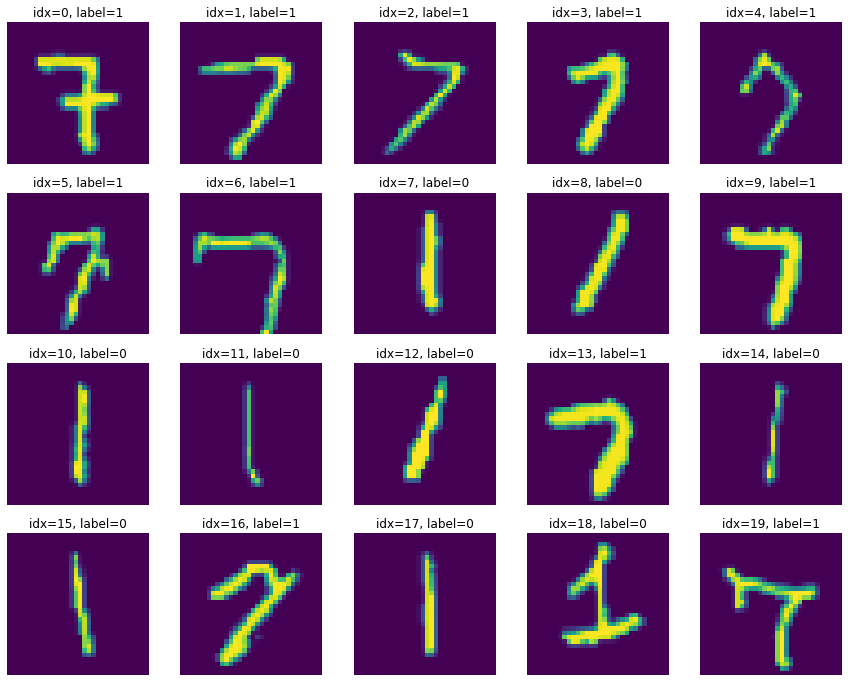

In [5]:
for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    break

plt.figure(figsize=(15,12))
for idx in range(20):
    plt.subplot(4,5,idx+1)
    plt.axis('off')
    plt.title('idx={}, label={}'.format(idx, y[idx].item()))
    plt.imshow(to_np(x[idx].permute(1,2,0)))

In [9]:
image_one = x[8].unsqueeze(0).clone()
image_seven = x[9].unsqueeze(0).clone()

import torchvision
from torch.utils import tensorboard
today = datetime.date.today()
loss_writer = tensorboard.SummaryWriter('logs/MNIST/loss/{}_{}'.format(today,args['description']))
image_writer = tensorboard.SummaryWriter('logs/MNIST/image/{}_{}'.format(today,args['description']))

start = time.time() ; print('Training starts!')

for epoch in range(args['Epochs']):
    M.train() ; P.train() ; G.train() ; D.train()
    for i, (imgs,labels) in enumerate(train_loader):
        batch_size = imgs.shape[0]
        real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_imgs = Variable(imgs.type(FloatTensor)).to(device)
        real_labels = to_discrete(labels.numpy(), args['n_classes']).to(device)
        labels = labels.to(device)
        encoded = E(real_imgs)        
        
        # -----------------
        #  Train Predictor
        # -----------------
        optimizer_P.zero_grad()
        code_P, code_G, latent = M(encoded.clone())
        predicted= P(code_P)
        loss_P = predict_loss(predicted, real_labels)

        loss_P.backward(retain_graph=True)
        optimizer_P.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        code_P, code_G, latent = M(encoded.clone())
        fake_imgs = G(real_labels, code_P, code_G, latent)
        reality, _, _, _ = D(fake_imgs)
        
        loss_adv = adversarial_loss(reality, real) # fake_imgs의 분류(D) 결과가 최대한 1(real)로 분류되도록 G 학습
        loss_recon = recon_loss(real_imgs, fake_imgs)
        # alpha = 0.1
        # loss_G = (alpha*loss_adv + (1-alpha)*loss_recon)
        loss_G = (loss_adv + 100*loss_recon)
        loss_G.backward(retain_graph=True)
        optimizer_G.step()
    
        # -----------------
        #  Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        code_P, code_G, latent = M(encoded.clone())
        # real or fake pred score
        pred_real, _, _, _ = D(real_imgs)
        pred_fake, _, _, _ = D(fake_imgs.detach())
        loss_D_real = adversarial_loss(pred_real, real) # real_imgs는 D가 1(real)로 분류하도록 D 학습 
        loss_D_fake = adversarial_loss(pred_fake, fake) # fake_imgs는 D가 0(fake)로 분류하도록 D 학습
        loss_D = (loss_D_real + loss_D_fake) / 2
        
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        
        # ------------------
        # Information Loss
        # ------------------
        optimizer_info.zero_grad()
        code_P, code_G, latent = M(encoded.clone())
        predicted = P(code_P)
        fake_imgs = G(real_labels, code_P, code_G, latent)
        _, pred_label, pred_code_P, pred_code_G = D(fake_imgs) # D라고 해놨지만 Q head의 출력임
        # pred_label = Variable(LongTensor(to_np(pred_label))).to(device)
        # labels = Variable(LongTensor(to_np(labels))).to(device)
        
        loss_info_disc = lambda_disc * discrete_loss(pred_label, real_labels) # 실제 레이블 예측(이산 CELoss)
        loss_info_code_P = lambda_code * code_loss(pred_code_P.clone(), code_P.clone()) # code_P 예측 (연속 MSELoss
        loss_info_code_G = lambda_code * code_loss(pred_code_G, code_G) # code_G 예측(연속 MSELoss)
        loss_info =  loss_info_disc + loss_info_code_P + loss_info_code_G
        
        loss_info.backward(retain_graph=True)
        optimizer_info.step()
        
        # optimizer_info_P.zero_grad()
        # # code_P, code_G, latent = M(encoded.clone())
        # # fake_imgs = G(real_labels, code_P, code_G, latent)
        # # _, pred_label, pred_code_P, pred_code_G = D(fake_imgs) # D라고 해놨지만 Q head의 출력임
        
        # loss_info_code_P.backward(retain_graph=True)
        # optimizer_info_P.step()
    
        # code만 고정된 경우 생성 image와 code만 interpolation하는 경우 생성 image 저장
        # batches_done = epoch * len(train_loader) + i
        # if batches_done % args['sample_interval'] == 0:
        #     sample_image(n_row=2, batches_done=batches_done)
            
    # --------------
    # Log Progress
    # --------------
    M.eval() ; P.eval() ; G.eval() ; D.eval()
    correct=0
    with torch.no_grad():
        for test_image, test_label in test_loader:
            batch_size = test_image.shape[0]
            test_image = test_image.to(device)
            test_label = test_label.to(device)
            code_P, code_G, latent = M(E(test_image).clone())
            output = P(code_P).to(device)
            prediction = output.max(1,keepdim=True)[1].to(device)
            correct += prediction.eq(test_label.view_as(prediction)).sum().item()

    test_accuracy = 100*correct / len(test_loader.dataset)

    print(
        "[Epoch %d/%d] [acc : %.2f] [P : %.4f] [D : %.4f] [G : %.4f] [info: %.4f] [code P: %.4f] [code G: %.4f] [time: %.1f]"
        % (epoch, args['Epochs'],
           test_accuracy,
        #    i, len(train_loader),
           loss_P.item(),
           loss_D.item(), 
           loss_G.item(), 
           loss_info.item(),
           loss_info_code_P.item(),
           loss_info_code_G.item(),
           time.time()-start)
    )
    
    sample, grid = sample_image(epoch=epoch)
    
    image_writer.add_image('sample', grid, epoch)
    loss_writer.add_scalar('loss_P', loss_P.item(), epoch)
    loss_writer.add_scalar('loss_D', loss_D.item(), epoch)
    loss_writer.add_scalar('loss_G', loss_G.item(), epoch)
    loss_writer.add_scalar('loss_info', loss_info.item(), epoch)
    loss_writer.add_scalar('loss_info_d', loss_info_disc.item(), epoch)
    loss_writer.add_scalar('loss_info_code_P', loss_info_code_P.item(), epoch)
    loss_writer.add_scalar('loss_info_code_G', loss_info_code_G.item(), epoch)
    loss_writer.add_scalar('accuracy', test_accuracy, epoch)
    
    # image_writer.add_image('static', , n_iter)
    # image_writer.add_image('c_p_varied', ,n_iter)
    # image_writer.add_image('c_g1_varied', ,n_iter)
    # image_writer.add_image('c_g2_varied', ,n_iter)

Training starts!


/root/anaconda3/envs/song/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch 0/200] [acc : 99.54] [P : 0.1421] [D : 0.0201] [G : 38.6425] [info: 0.4268] [code P: 0.0200] [code G: 0.0740] [time: 13.9]
[Epoch 1/200] [acc : 99.65] [P : 0.0907] [D : 0.0186] [G : 15.6749] [info: 0.4146] [code P: 0.0266] [code G: 0.0364] [time: 27.3]
[Epoch 2/200] [acc : 99.69] [P : 0.0125] [D : 0.0159] [G : 13.7429] [info: 0.3414] [code P: 0.0086] [code G: 0.0172] [time: 41.6]
[Epoch 3/200] [acc : 99.62] [P : 0.1436] [D : 0.0363] [G : 10.7493] [info: 0.3769] [code P: 0.0186] [code G: 0.0147] [time: 55.6]
[Epoch 4/200] [acc : 99.69] [P : 0.0104] [D : 0.0225] [G : 9.4666] [info: 0.3371] [code P: 0.0090] [code G: 0.0124] [time: 69.9]
[Epoch 5/200] [acc : 98.96] [P : 0.0040] [D : 0.0221] [G : 12.2019] [info: 0.3799] [code P: 0.0285] [code G: 0.0214] [time: 83.1]
[Epoch 6/200] [acc : 99.65] [P : 0.0025] [D : 0.0263] [G : 9.2078] [info: 0.3317] [code P: 0.0075] [code G: 0.0088] [time: 97.7]
[Epoch 7/200] [acc : 99.54] [P : 0.0025] [D : 0.0493] [G : 8.3110] [info: 0.3441] [code P: 0

## Test!

In [ ]:
image_one = x[25].unsqueeze(0).clone()
image_seven = x[10].unsqueeze(0).clone()
sample_image(300);

In [ ]:
for i, (imgs,labels) in enumerate(train_loader):
    batch_size = imgs.shape[0]
    real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
    fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)
    
    real_imgs = Variable(imgs.type(FloatTensor)).to(device)
    real_labels = to_discrete(labels.numpy(), args['n_classes']).to(device)
    labels = labels.to(device)
    encoded = E(real_imgs)
    break

In [ ]:
# print('disc :', one_repeat.shape)
# print('inter_p :', inter_p.shape)
# print('inter_g1 :', inter_g1.shape)
# print('inter_g2 :', inter_g2.shape)
# print('latent :', latent_repeat.shape)
# print('one_p_latent :', torch.cat([one_repeat, inter_p, latent_repeat], dim=-1).shape)
# print('sample :', sample_one.shape)


disc : torch.Size([10, 2])
inter_p : torch.Size([10, 3])
inter_g1 : torch.Size([10, 3])
inter_g2 : torch.Size([10, 3])
latent : torch.Size([10, 32])
one_p_latent : torch.Size([10, 37])
sample : torch.Size([10, 1, 32, 32])


In [ ]:
print(code_P.shape, code_G.shape, latent.shape)

torch.Size([1, 1]) torch.Size([1, 2]) torch.Size([1, 32])


In [ ]:
# import datetime
# torch.save(E, 'pretrained_model/main/first_success_E.pt')
# torch.save(P, 'pretrained_model/main/first_success_P.pt')
# torch.save(G, 'pretrained_model/main/first_success_G.pt')
# torch.save(D, 'pretrained_model/main/first_success_D.pt')

# torch.save(E.state_dict(), '{}/pretrained_model/main/first_success_E_state.pt')
# torch.save(P.state_dict(), 'pretrained_model/main/first_success_P_state.pt')
# torch.save(G.state_dict(), 'pretrained_model/main/first_success_G_state.pt')
# torch.save(D.state_dict(), 'pretrained_model/main/first_success_D_state.pt')